In [1]:
import pandas as pd
import numpy as np
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

image is a 2d numpy array
image is 2d of numbers (greyscale image)

In [3]:
# Assumption image is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image, coords, FOV):
    ft_image = np.fft.fftshift(np.fft.fft2(image)) # Investigate to make sure what this fft does
    # Check bounds here -128 to 127 or -127 to 128!!!

    kx_1 = 2*math.pi/FOV
    """u_translated = 1/kx_1 #u/kx_1
    v_translated = 1/kx_1 #v/kx_1"""

    kx = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[0])//2 - 1, ft_image.shape[0])
    ky = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[1])//2 - 1, ft_image.shape[1])
    
    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="cubic")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="cubic")

    # Rescale Coords
    translated_coords = np.divide(coords,kx_1)

    real = interp_real(coords)
    imag = interp_imag(coords)
    return real + imag * 1j

Testing Interpolate

In [4]:
n = 256

a = np.linspace(-50, 50, n)
x, y = np.meshgrid(a, a)

k = np.fft.fftfreq(n, a[1]-a[0])
kx, ky = np.meshgrid(k, k)

def Gaussian(sigma, x0=0, y0=0):
    dx = x - x0
    dy = y - y0
    return np.exp(-0.5 * (dx*dx + dy*dy) / (sigma * sigma))

def ring(nn=0.01):
    return np.maximum(Gaussian(10, *randpos(1)) - Gaussian(8, *randpos(1)), 0) + nn * noise(2)

def noise(alpha):
    white_noise = np.random.rand(n, n)-0.5 + 1j*(np.random.rand(n, n)-0.5)
    power_law = np.power(kx*kx + ky*ky + 1e-300, -0.5 * alpha)
    power_law[0,0] = 0
    img  = np.real(np.fft.ifft2(white_noise * power_law))
    img += np.min(img)
    img /= np.max(img)
    return img

def randpos(scale=1):
    x = (np.random.rand() - 0.5) * 2 * scale
    y = (np.random.rand() - 0.5) * 2 * scale
    return x, y

(-0.5, 255.5, 255.5, -0.5)

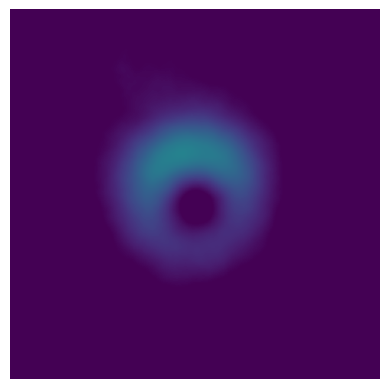

In [6]:
sample = ring() # Sample is 256 by 256
plt.figure()
#cm = copy(plt.get_cmap('afmhot'))
#cm.set_over('b')
plt.imshow(sample, vmin=0, vmax=0.5)
plt.axis('off')

In [8]:
samp = np.array(sample)
samp_blank = samp * 0
samp_coords = [[1.81243945e-03+0.j, -1.65010891e-02-0.01426895j]]
temp_1 = interpolate(samp, samp_coords, 100 * u.uas)
print(temp_1)
temp_2 = interpolate(samp_blank, samp_coords, 100 * u.uas)
print(temp_2)

[-154.58283954+4.69346377j]
[0.+0.j]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_rgi.py:374: ComplexWarning: Casting complex values to real discards the imaginary part
  xi = np.asarray(xi, dtype=float)


In [9]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = 0
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = 0

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))

        """for l in range(len(image)-1): # Turn this into numpy operations
            for m in range(len(image[l])-1):
                reg += (abs(image[l+1][m] - image[l][m])**p + abs(image[l][m+1] - image[l][m])**p)"""
    return reg

In [ ]:
testing


Translate u and v to a position to grid
    => Translate from gigalambda to grid
    ImageMeta(width=100 * u.uas)
    uvd  = width_in_as * 2 * pi
    divide by kx_1
    relates to integer indexes
python fftshift to array
    By default fft array is 0 is on the corner, negatives gets wrapped
    fftshift will centralize the 0 to the middle
python's RegularGridInterpolator will interpolate
    Research whether they support complex values now
    If not:
        Interpolate Real part and imagineary part separately

In [10]:
# Assumption image is 80px by 80px => 6400 variables
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 10000*u.uas.to(u.rad)):
    error_sum = 0
    vis_images = interpolate(image, coords, FOV) # Bottleneck...
    
    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase))
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

In [11]:
sample_coords = []
sample_data_list = []
print(loss(samp, sample_data_list, sample_coords))
print(loss(samp_blank, sample_data_list, sample_coords))


0.7788939901537362
0.0


In [12]:
def gradient(data_list: list[data], coords, image, central = False, backward = False):
    image_copy = np.copy(image, subok=True)
    upper_diff: float
    lower_diff: float
    h: float
    gradient_arr = np.empty(np.shape(image),dtype=np.complex_)
    if central: # Central difference
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-6 / 2
                upper_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] -= 1e-6
                lower_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] = image[row,col] # Reset that pixel to original value
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-6
    elif backward: # Backward difference
        upper_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] -= 1e-8 # Check with Misha 
                lower_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    else: # Forward difference is default
        lower_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-8 # Check with Misha 
                upper_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    return gradient_arr
    #Return a Gradient 2d array?

In [25]:
emp = np.empty((80,80))
#x = gradient(data_list, coords, emp)
#np.divide(coords,2*math.pi/(100*u.uas.to(u.rad))) # Think about size of image too for FOV

In [13]:
def gradient_2(data_list: list[data], coords, coeffs, image, FOV = 100*u.uas.to(u.rad)):
    gradient_arr = np.empty(np.shape(image), dtype=np.complex_)
    vis_images = interpolate(image, coords, FOV) # FOV still broken
    for row in range(len(image)):
        for col in range(len(image[row])):
            gradient_sum = 0
            for i in range(len(data_list)):
                vis_data = data_list[i].vis_data
                vis_image = vis_images[i]
                term_1 = coeffs[row,col,i,0] * (np.conj(vis_image) - np.conj(vis_data))
                term_2 = coeffs[row,col,i,1] * (vis_image - vis_data)
                gradient_sum += (term_1 + term_2)/(data_list[i].sigma ** 2)
            gradient_arr[row,col] = gradient_sum
    return gradient_arr

In [14]:
def preprocess_gradient(data_list: list[data], coords, image):
    r, c = np.shape(image)
    preprocessed = np.empty([r,c,len(data_list),2], dtype=np.complex_)
    for row in range(len(image)):
        for col in range(len(image[row])):
            for datum in range(len(data_list)):
                term = ((2*np.pi*1j)/image.size)*(row*data_list[datum].u + col*data_list[datum].v) #.size for numpy array returns # of rows * # of cols
                term_1 = np.exp(term)
                term_2 = np.exp(-1*term)
                preprocessed[row,col,datum,0] = term_1
                preprocessed[row,col,datum,1] = term_2
    return preprocessed

coordinate descent method: Optimize with respect to a var, then freeze and optimize with another 
                           var... continue until reach a optimum
                           or subset of vars
Gauss-seidel Method: Use idea from here, don't actually try coding this
Stochastic gradient descent: The later stages you use, the more of the data in your subset
                             Start with a subset (representative, spread out over the data)
                             Random subset? 
Is there a quick way to compute dirty version of image
Gradient of Regularizers

Github
HPC Benchmark
Stochastic gradient descent: The later stages you use, the more of the data in your subset
    Start with a subset (representative, spread out over the data)
    Random subset? 
    subset like 10%
    
    # generating random samples without replacement
    print(np.random.choice(prog_langs, size=3, replace=False))

Gradient of Regularizers

In [21]:
coeffs = preprocess_gradient(data_list, coords, emp)

In [43]:
coeffs

array([[[[ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         ...,
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j]],

        [[ 0.72896863-6.84547106e-01j,  0.72896863+6.84547106e-01j],
         [-0.42577929-9.04827052e-01j, -0.42577929+9.04827052e-01j],
         [ 0.79075635-6.12131026e-01j,  0.79075635+6.12131026e-01j],
         ...,
         [ 0.46619364+8.84682704e-01j,  0.46619364-8.84682704e-01j],
         [-0.68724289+7.26427708e-01j, -0.68724289-7.26427708e-01j],
         [ 0.32205916+9.46719545e-01j,  0.32205916-9.46719545e-01j]],

        [[ 0.06279052-9.98026728e-01j,  0.06279052+9.98026728e-01j],
         [-0.63742399+7.70513243e-01j, -0.63742399-7.70513243e-01j],
  

In [23]:
emp = np.empty((80,80))
x = gradient_2(data_list, coords, coeffs, emp)
#np.divide(coords,2*math.pi/(10000*u.uas.to(u.rad)))

In [15]:
def process_data(data_df):
    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [16]:
def read_data(filename: str()):
    df = pd.read_csv(filename)
    return df

In [17]:
df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
df


,#time(UTC),T1,T2,U(lambda),V(lambda),Iamp(Jy),Iphase(d),Isigma(Jy)
0,0.768056,AA,LM,1.081710e+09,-3.833722e+09,0.014292,-118.9454,0.005847
1,0.768056,AA,PV,-4.399933e+09,-4.509480e+09,0.136734,5.8638,0.004968
2,0.768056,AA,AP,8.349088e+05,-1.722271e+06,1.119780,58.1095,0.005243
3,0.768056,AP,LM,1.080840e+09,-3.832004e+09,0.018448,-137.6802,0.044576
4,0.768056,AP,PV,-4.400757e+09,-4.507747e+09,0.139619,-57.1724,0.032591
...,...,...,...,...,...,...,...,...
6453,8.165278,AZ,LM,-1.078324e+09,1.029597e+09,0.315983,10.9377,0.030449
6454,8.165278,AZ,JC,3.392180e+09,9.968579e+08,0.058864,46.0474,0.090288
6455,8.165278,JC,LM,-4.470504e+09,3.273711e+07,0.108582,-178.7050,0.043965
6456,8.165278,JC,SM,1.745735e+04,-1.192282e+05,1.123722,-29.5589,0.091870


In [18]:
coords, data_list = process_data(df)
len(data_list)

6458

Don't combine u and v into. They are 2D coordinates in fourier transform
vis = amp * np.exp(1j * phase)
turn phase into radians
interpolation to get sample value
80 pixel x 80 pixel

Find FOV
    => Hyperparameter
    => 100 microasc

# Add regularizers Here
    # need it for good restorations L2 Norm penalty
    # First (25) reg with variable p instead of 2
    # Write optimization loop (Gradient Descent?)
    # Reorg above
    # Hardcode Gradient Descent of data term in terms of function
    # Gradient by finding images pixel by pixel => Combine after to get final image NOOO
    # Does pytorch autodiff work with fft?

    # How long does it take to compute one gradient
    # Can use Central difference to approx gradient
    # h is.. check video, like 10^-6
    # forward difference will be faster but less accurate
    # Try both?

    # regularizers smooths out the image, doesn't like "rough" images
    # Make pixel next to each other similar to each other

In [199]:
y = train_df['complex'].values
y = y.reshape(-1, 1)
train_df['constant'] = 1
columns = ['U(lambda)', 'V(lambda)', 'Isigma(Jy)']
x = train_df[columns].values

#initialize vector of weights
w = np.zeros([x.shape[0], 2])
print(w.shape)

(99, 2)


In [37]:
A = np.array([[4, 3, 2],
              [1, 2, 3],
              [0, -1, 5]])
B = np.empty(np.shape(A))

How slow is finite differences
Try to implement and understand the derivatives one works

In [145]:
def f(x, y, z):
    return 2 * x**3 + y**4 - z

x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)

xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

data = f(xg, yg, zg)
interp = RegularGridInterpolator((x, y, z), data, bounds_error=False, method="cubic")
pts = np.array([[2.1, 6.2, 8.3],
                [3.3, 5.2, 7.1],
                [2.5, 5.5, 8.5],
                [1.00000001, 4.0000000000000001, 7.00008]])
for pt in pts:
    print(interp(pt))
    print(f(pt[0],pt[1],pt[2]))
    print("---------------------")

[1487.85557568]
1487.8556
---------------------
[795.93557602]
795.9356000000001
---------------------
[937.81247397]
937.8125
---------------------
[250.99992006]
250.99992006
---------------------


Runge Phenomenon and Gibbs

In [5]:
x = np.array([[0,1,2],[4,5,6]])
np.shape(x)

(2, 3)